# Assignment 3: Job Salary Prediction

Student Name: `Hugo Akindele-Obe`

Student ID: `1444970`

## Research Question: Does Unlabelled data improve Job salary prediction?

### General Info:
This workbook accompanies the report _Does Self-Training Using Unlabelled data Improve Job Salary Classification?_.
It includes logistic regression, _k_-nearest neighbours, and multinomial naive bayes models trained in both supervised and semi-supervised contexts for the prediction of job salary based on job description features.


In [23]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

__Importing data__:<br>
Importing and separating the data into training, validating, and testing sets, and separate training and validation sets for different feature representations (raw, TF-IDF, embeddings).

In [26]:
raw_train_data = pd.read_csv("data/raw-data/train.csv")
raw_valid_data = pd.read_csv("data/raw-data/valid.csv")
raw_test_data = pd.read_csv("data/raw-data/test.csv")

emb_train_data = pd.DataFrame(np.load("data/embeddings-data/train-embeddings.npy"))
X_valid_emb = pd.DataFrame(np.load("data/embeddings-data/valid-embeddings.npy"))
X_test_emb = pd.DataFrame(np.load("data/embeddings-data/test-embeddings.npy"))

tfidf_train_data = pd.DataFrame(np.load("data/tfidf-data/train-tfidf.npy"))
X_valid_tfidf = pd.DataFrame(np.load("data/tfidf-data/valid-tfidf.npy"))
X_test_tfidf = pd.DataFrame(np.load("data/tfidf-data/test-tfidf.npy"))

# LABELS - only contains salary bin
y_train_lab = raw_train_data.iloc[:8000, 2]
y_valid = raw_valid_data.iloc[:,2]
y_train_all = raw_train_data.iloc[:, 2]
y_train_all = np.nan_to_num(y_train_all, nan=-1)

# RAW DATA - Only contains job description features
X_train_lab_raw = raw_train_data.iloc[:8000, 1]
X_train_unlab_raw = raw_train_data.iloc[8000:, 1]
X_valid_raw = raw_valid_data.iloc[:,1]
X_test_raw = raw_test_data.iloc[:,1]

# EMBEDDED DATA
X_train_lab_emb = emb_train_data.iloc[:8000, :]
X_train_unlab_emb = emb_train_data.iloc[8000:, :]

# TFIDF DATA
X_train_lab_tfidf = tfidf_train_data.iloc[:8000, :]
X_train_unlab_tfidf = tfidf_train_data.iloc[8000:, :]

print("Labelled training instances:",X_train_lab_raw.shape[0])
print("Unlabelled training instances:",X_train_unlab_raw.shape[0])
print("Validation instances:", X_valid_raw.shape[0])
print("Testing instances:", X_test_raw.shape[0])

Labelled training instances: 8000
Unlabelled training instances: 5902
Validation instances: 1737
Testing instances: 1738


__Label Distribution__:<br>
Checking the target labels are evenly distributed (this should be the case as specified in the spec).

<AxesSubplot:>

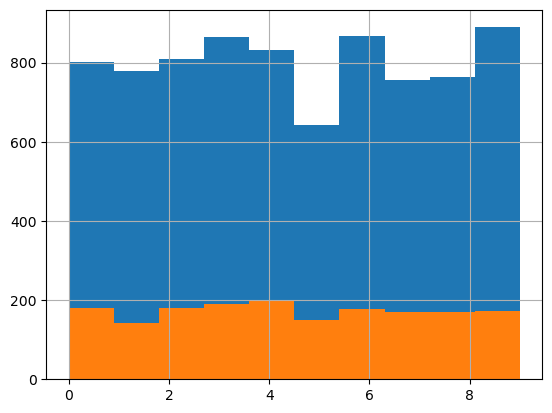

In [9]:
y_train_lab.hist()
y_valid.hist()

__Baseline Models__: <br>
Baseline Zero-R model as well as base LR, KNN, and MNB supervised classifiers on both the TF-IDF and embeddings data. MNB isn't trained on the embeddings as the negative values are invalid inputs for it.<br>
Additionally, model performance on their training data is checked.

In [11]:
# Zero-R
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_lab_raw, y_train_lab)
print("Zero-R:\t", dummy.score(X_valid_raw, y_valid).round(4))

Zero-R:	 0.0996


In [29]:
LR = LogisticRegression(max_iter=250)
KNN = KNeighborsClassifier(n_neighbors=20)
MNB = MultinomialNB(alpha=0.7)

print("----TF-IDF----")
LR.fit(X_train_lab_tfidf, y_train_lab)
print("LR:\t", LR.score(X_valid_tfidf, y_valid).round(4))
KNN.fit(X_train_lab_tfidf, y_train_lab)
print("KNN:\t", KNN.score(X_valid_tfidf, y_valid).round(4))
MNB.fit(X_train_lab_tfidf, y_train_lab)
print("MNB:\t", MNB.score(X_valid_tfidf, y_valid).round(4))

print("----Embeddings----")
LR.fit(X_train_lab_emb, y_train_lab)
print("LR:\t", LR.score(X_valid_emb, y_valid).round(4))
KNN.fit(X_train_lab_emb, y_train_lab)
print("KNN:\t", KNN.score(X_valid_emb, y_valid).round(4))

print("----Train Data----")
print("LR:\t", LR.score(X_train_lab_emb, y_train_lab).round(4))
print("KNN:\t", KNN.score(X_train_lab_emb, y_train_lab).round(4))
print("MNB:\t", MNB.score(X_train_lab_tfidf, y_train_lab).round(4))

----TF-IDF----
LR:	 0.2182
KNN:	 0.1773
MNB:	 0.2326
----Embeddings----
LR:	 0.2435
KNN:	 0.2378
----Train Data----
LR:	 0.3291
KNN:	 0.3368
MNB:	 0.3064


__Parameter Tuning__:<br>
Tuning of each the relevant parameters of each model. Max iterations for LR, number of neighbours for KNN, and alpha smoothing for MNB.

In [13]:
# FIND BEST PARAM FOR LOGISTIC REGRESSION
warnings.simplefilter(action='ignore', category=UserWarning)
# Define the parameter grid to search over
param_grid = {'max_iter': [100, 250, 500, 1000, 5000]}
grid_search = GridSearchCV(LR, param_grid, cv=5)
grid_search.fit(X_train_lab_emb, y_train_lab)

# Print the best parameters and accuracy score
print("Best max_iter value:", grid_search.best_params_['max_iter'])
print("Accuracy:", grid_search.score(X_valid_emb, y_valid))

Best max_iter value: 250
Accuracy: 0.24352331606217617


In [14]:
# FIND BEST PARAM FOR KNN
# Define the parameter grid to search over
param_grid = {'n_neighbors': [5,10,20,30]}
grid_search = GridSearchCV(KNN, param_grid, cv=5)
grid_search.fit(X_train_lab_emb, y_train_lab)

print("Best n_neighbors value:", grid_search.best_params_['n_neighbors'])
print("Accuracy:", grid_search.score(X_valid_emb, y_valid))

Best n_neighbors value: 20
Accuracy: 0.2377662636729994


In [19]:
# FIND BEST PARAM FOR MNB
# Define the parameter grid to search over
param_grid = {'alpha':[0.7,0.8,0.9,1.0,2]}
grid_search = GridSearchCV(MNB, param_grid, cv=5)
grid_search.fit(X_train_lab_tfidf, y_train_lab)

print("Best alpha value:", grid_search.best_params_['alpha'])
print("Accuracy:", grid_search.score(X_valid_tfidf, y_valid))

Best alpha value: 0.7
Accuracy: 0.23258491652274035


__Self-Training Models__:<br>
Each of LR, KNN, and MNB models are used as base classifiers for SelfTrainingClassifier.<br>
They are trained on the labelled and unlabelled data at a range of thresholds and assessed against the validation data.<br>
Output is a plot of accuracy as the threshold increases along with metrics at each threshold.

In [20]:
def plotAccByThreshold(thresholds, accs, num_labelled, num_instances, rounds):
    ax1 = plt.subplot(211)
    ax1.plot(thresholds, accs, color="b")
    ax1.set_ylabel("Accuracy", color="b")
    ax1.tick_params("y", colors="b")

    ax2 = ax1.twinx()
    ax2.set_ylim(bottom=0, top=num_instances)
    ax2.set_ylabel("Amount of labeled samples", color="g")
    ax2.tick_params("y", colors="g")
    ax2.plot(thresholds, num_labelled, color="g")

    ax3 = plt.subplot(212, sharex=ax1)
    ax3.set_ylim(bottom=0, top=30)
    ax3.set_ylabel("Amount of iterations")
    ax3.set_xlabel("Threshold")
    ax3.plot(thresholds, rounds, color="b")
    plt.show()

In [21]:
# Define threshold space to test over
thresholds = np.arange(0.3, 1.0, 0.05)
thresholds = np.append(thresholds, 0.999)

THRESHOLDS -- LOGISTIC REGRESSION
Total instances:	 13902
Threshold: 0.30 | Acc: 0.2309 	Labelled: 3471 	Iterations: 30 	F1: 0.1767 	Prec: 0.2222 	Rec:0.2284
Threshold: 0.35 | Acc: 0.2389 	Labelled: 1925 	Iterations: 18 	F1: 0.1892 	Prec: 0.2074 	Rec:0.2344
Threshold: 0.40 | Acc: 0.2453 	Labelled: 1332 	Iterations: 12 	F1: 0.2022 	Prec: 0.2160 	Rec:0.2408
Threshold: 0.45 | Acc: 0.2441 	Labelled: 864 	Iterations: 14 	F1: 0.2071 	Prec: 0.2100 	Rec:0.2398
Threshold: 0.50 | Acc: 0.2447 	Labelled: 520 	Iterations: 10 	F1: 0.2126 	Prec: 0.2112 	Rec:0.2412
Threshold: 0.55 | Acc: 0.2441 	Labelled: 277 	Iterations: 7 	F1: 0.2160 	Prec: 0.2158 	Rec:0.2410
Threshold: 0.60 | Acc: 0.2435 	Labelled: 162 	Iterations: 6 	F1: 0.2183 	Prec: 0.2178 	Rec:0.2407
Threshold: 0.65 | Acc: 0.2441 	Labelled: 85 	Iterations: 7 	F1: 0.2206 	Prec: 0.2201 	Rec:0.2416
Threshold: 0.70 | Acc: 0.2441 	Labelled: 32 	Iterations: 3 	F1: 0.2210 	Prec: 0.2201 	Rec:0.2419
Threshold: 0.75 | Acc: 0.2447 	Labelled: 16 	Iteration

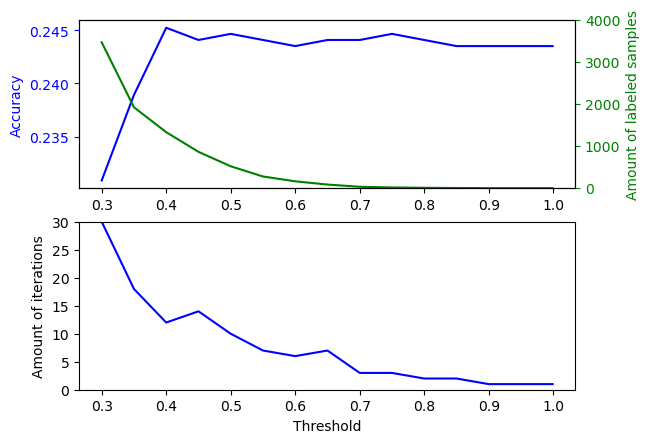

In [27]:
# LOGISTIC REGRESSION
LR = LogisticRegression(max_iter=250)

self_LR_accs = []
self_LR_f1s = []
self_LR_precs = []
self_LR_recs = []
self_LR_labelled = []
self_LR_rounds = []

start = time.time()

for threshold in thresholds:
    self_LR = SelfTrainingClassifier(LR, threshold=threshold, max_iter=30)
    
    # Train the model on labelled and unlabelled data
    self_LR.fit(emb_train_data, y_train_all)
    
    # Predict validation instances
    Y_valid_emb_pred = self_LR.predict(X_valid_emb)
    
    # Store iteration performance
    self_LR_accs.append(accuracy_score(y_valid, Y_valid_emb_pred))
    self_LR_f1s.append(f1_score(y_valid, Y_valid_emb_pred, average='macro')) 
    self_LR_precs.append(precision_score(y_valid, Y_valid_emb_pred, average='macro')) 
    self_LR_recs.append(recall_score(y_valid, Y_valid_emb_pred, average='macro')) 
    labelled_or_not = self_LR.labeled_iter_
    self_LR_labelled.append(labelled_or_not[np.where(labelled_or_not > 0)].shape[0])
    self_LR_rounds.append(self_LR.n_iter_)

end = time.time()

print("THRESHOLDS -- LOGISTIC REGRESSION")
print("Total instances:\t", emb_train_data.shape[0])
for i in range(thresholds.size):
    print("Threshold: %.2f" % thresholds[i].round(2), "| ", end='')
    print("Acc: %.4f" % self_LR_accs[i].round(4), "\t", end='')
    print("Labelled:", self_LR_labelled[i], "\t", end='')
    print("Iterations:", self_LR_rounds[i], "\t", end='')
    print("F1: %.4f" % self_LR_f1s[i].round(4), "\t", end='')
    print("Prec: %.4f" % self_LR_precs[i].round(4), "\t", end='')
    print("Rec:%.4f" % self_LR_recs[i].round(4))
    
print("Time:\t", end-start)

plotAccByThreshold(thresholds, self_LR_accs, self_LR_labelled, 4000, self_LR_rounds)

THRESHOLDS -- KNN
Total instances: 13902
Threshold: 0.30 | Acc: 0.2170 	Labelled: 4343 	Iterations: 15 	F1: 0.1997 	Prec: 0.2286 	Rec:0.2200
Threshold: 0.35 | Acc: 0.2222 	Labelled: 2989 	Iterations: 17 	F1: 0.2032 	Prec: 0.2178 	Rec:0.2250
Threshold: 0.40 | Acc: 0.2222 	Labelled: 2989 	Iterations: 17 	F1: 0.2032 	Prec: 0.2178 	Rec:0.2250
Threshold: 0.45 | Acc: 0.2234 	Labelled: 1754 	Iterations: 18 	F1: 0.2096 	Prec: 0.2186 	Rec:0.2261
Threshold: 0.50 | Acc: 0.2291 	Labelled: 651 	Iterations: 9 	F1: 0.2186 	Prec: 0.2201 	Rec:0.2307
Threshold: 0.55 | Acc: 0.2303 	Labelled: 314 	Iterations: 9 	F1: 0.2202 	Prec: 0.2188 	Rec:0.2320
Threshold: 0.60 | Acc: 0.2366 	Labelled: 187 	Iterations: 15 	F1: 0.2262 	Prec: 0.2239 	Rec:0.2380
Threshold: 0.65 | Acc: 0.2360 	Labelled: 97 	Iterations: 7 	F1: 0.2263 	Prec: 0.2242 	Rec:0.2375
Threshold: 0.70 | Acc: 0.2383 	Labelled: 47 	Iterations: 5 	F1: 0.2285 	Prec: 0.2264 	Rec:0.2398
Threshold: 0.75 | Acc: 0.2383 	Labelled: 47 	Iterations: 5 	F1: 0.2285

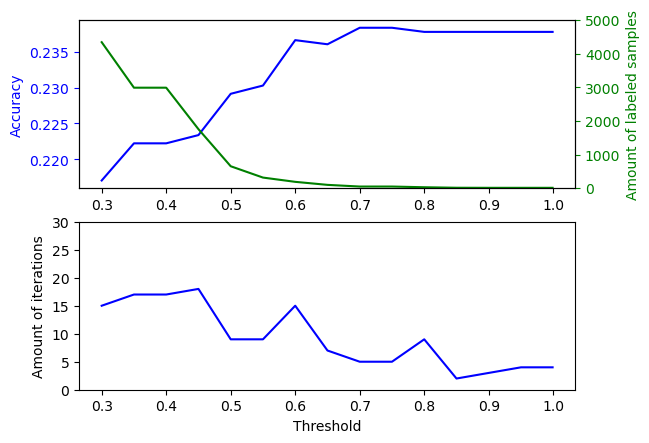

In [28]:
# K-NEAREST NEIGHBOURS
KNN = KNeighborsClassifier(n_neighbors=20, metric="cosine")

self_KNN_accs = []
self_KNN_f1s = []
self_KNN_precs = []
self_KNN_recs = []
self_KNN_labelled = []
self_KNN_rounds = []

start = time.time()

for threshold in thresholds:
    self_KNN = SelfTrainingClassifier(KNN, threshold=threshold, max_iter=30)
    
    # Train the model on labelled and unlabelled data
    self_KNN.fit(emb_train_data, y_train_all)
    
    # Predict validation instances
    Y_valid_emb_pred = self_KNN.predict(X_valid_emb)
    
    # Store iteration performance
    self_KNN_accs.append(accuracy_score(y_valid, Y_valid_emb_pred))
    self_KNN_f1s.append(f1_score(y_valid, Y_valid_emb_pred, average='macro')) 
    self_KNN_precs.append(precision_score(y_valid, Y_valid_emb_pred, average='macro')) 
    self_KNN_recs.append(recall_score(y_valid, Y_valid_emb_pred, average='macro')) 
    labelled_or_not = self_KNN.labeled_iter_
    self_KNN_labelled.append(labelled_or_not[np.where(labelled_or_not > 0)].shape[0])
    self_KNN_rounds.append(self_KNN.n_iter_)

end = time.time()

print("THRESHOLDS -- KNN")
print("Total instances:", emb_train_data.shape[0])
for i in range(thresholds.size):
    print("Threshold: %.2f" % thresholds[i].round(2), "| ", end='')
    print("Acc: %.4f" % self_KNN_accs[i].round(4), "\t", end='')
    print("Labelled:", self_KNN_labelled[i], "\t", end='')
    print("Iterations:", self_KNN_rounds[i], "\t", end='')
    print("F1: %.4f" % self_KNN_f1s[i].round(4), "\t", end='')
    print("Prec: %.4f" % self_KNN_precs[i].round(4), "\t", end='')
    print("Rec:%.4f" % self_KNN_recs[i].round(4))
    
print("Time:\t", end-start)

plotAccByThreshold(thresholds, self_KNN_accs, self_KNN_labelled, 5000, self_KNN_rounds)

THRESHOLDS -- MNB
Total instances: 13902
Threshold: 0.30 | Acc: 0.2101 	Labelled: 4356 	Iterations: 15 	F1: 0.1319 	Prec: 0.2108 	Rec:0.2085
Threshold: 0.35 | Acc: 0.2101 	Labelled: 2369 	Iterations: 18 	F1: 0.1403 	Prec: 0.1930 	Rec:0.2056
Threshold: 0.40 | Acc: 0.2170 	Labelled: 1628 	Iterations: 12 	F1: 0.1552 	Prec: 0.1775 	Rec:0.2115
Threshold: 0.45 | Acc: 0.2193 	Labelled: 1148 	Iterations: 17 	F1: 0.1637 	Prec: 0.1773 	Rec:0.2139
Threshold: 0.50 | Acc: 0.2303 	Labelled: 680 	Iterations: 15 	F1: 0.1813 	Prec: 0.1845 	Rec:0.2248
Threshold: 0.55 | Acc: 0.2349 	Labelled: 282 	Iterations: 21 	F1: 0.1936 	Prec: 0.1915 	Rec:0.2301
Threshold: 0.60 | Acc: 0.2326 	Labelled: 45 	Iterations: 5 	F1: 0.2001 	Prec: 0.2064 	Rec:0.2295
Threshold: 0.65 | Acc: 0.2314 	Labelled: 28 	Iterations: 6 	F1: 0.1995 	Prec: 0.2057 	Rec:0.2284
Threshold: 0.70 | Acc: 0.2320 	Labelled: 5 	Iterations: 2 	F1: 0.2013 	Prec: 0.2076 	Rec:0.2288
Threshold: 0.75 | Acc: 0.2314 	Labelled: 3 	Iterations: 2 	F1: 0.2005 	

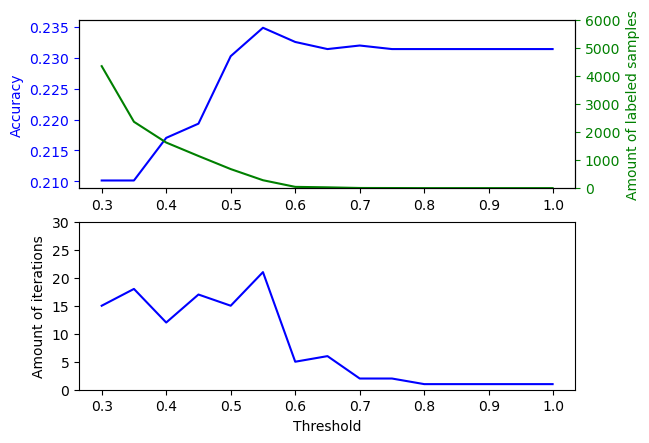

In [30]:
# MULTINOMIAL NAIVE BAYES
MNB = MultinomialNB(alpha=0.5)

self_MNB_accs = []
self_MNB_f1s = []
self_MNB_precs = []
self_MNB_recs = []
self_MNB_labelled = []
self_MNB_rounds = []

start = time.time()

for threshold in thresholds:
    self_MNB = SelfTrainingClassifier(MNB, threshold=threshold, max_iter=30)
    
    # Train the model on labelled and unlabelled data
    self_MNB.fit(tfidf_train_data, y_train_all)
    
    # Predict validation instances
    Y_valid_tfidf_pred = self_MNB.predict(X_valid_tfidf)
    
    # Store iteration performance
    self_MNB_accs.append(accuracy_score(y_valid, Y_valid_tfidf_pred))
    self_MNB_f1s.append(f1_score(y_valid, Y_valid_tfidf_pred, average='macro')) 
    self_MNB_precs.append(precision_score(y_valid, Y_valid_tfidf_pred, average='macro', zero_division=0)) 
    self_MNB_recs.append(recall_score(y_valid, Y_valid_tfidf_pred, average='macro')) 
    labelled_or_not = self_MNB.labeled_iter_
    self_MNB_labelled.append(labelled_or_not[np.where(labelled_or_not > 0)].shape[0])
    self_MNB_rounds.append(self_MNB.n_iter_)

end = time.time()

print("THRESHOLDS -- MNB")
print("Total instances:", tfidf_train_data.shape[0])
for i in range(thresholds.size):
    print("Threshold: %.2f" % thresholds[i].round(2), "| ", end='')
    print("Acc: %.4f" % self_MNB_accs[i].round(4), "\t", end='')
    print("Labelled:", self_MNB_labelled[i], "\t", end='')
    print("Iterations:", self_MNB_rounds[i], "\t", end='')
    print("F1: %.4f" % self_MNB_f1s[i].round(4), "\t", end='')
    print("Prec: %.4f" % self_MNB_precs[i].round(4), "\t", end='')
    print("Rec:%.4f" % self_MNB_recs[i].round(4))
    
print("Time:\t", end-start)

plotAccByThreshold(thresholds, self_MNB_accs, self_MNB_labelled, 6000, self_MNB_rounds)

__Saving__ best threshold model performances to csv for test Kaggle submissions.

In [31]:
# Save best model performance results to disk
# self_LR = SelfTrainingClassifier(LR, threshold=0.75, max_iter=30)
# self_LR.fit(emb_train_data, y_train_all)
# self_LR_pred = self_LR.predict(X_test_emb)
# pred2submission(self_LR_pred).to_csv("report_results/self_training/self_LR_pred.csv", index=False)

# self_KNN = SelfTrainingClassifier(KNN, threshold=0.75, max_iter=30)
# self_KNN.fit(emb_train_data, y_train_all)
# self_KNN_pred = self_KNN.predict(X_test_emb)
# pred2submission(self_KNN_pred).to_csv("report_results/self_training/self_KNN_pred.csv", index=False)

# self_MNB = SelfTrainingClassifier(MNB, threshold=0.70, max_iter=30)
# self_MNB.fit(tfidf_train_data, y_train_all)
# self_MNB_pred = self_MNB.predict(X_test_tfidf)
# pred2submission(self_MNB_pred).to_csv("report_results/self_training/self_MNB_pred.csv", index=False)

__Calibrated Models__:<br>
Per sklearn's documentation, SelfTrainingClassifiers benefit from calibration. <br>
First, each regular supervised LR, KNN, and MNB model is calibrated using an isotonic regressor. <br>
Then, these are used as base classifiers for new SelfTrainingClassifiers, and the same comparisons from earlier are repeated.

In [32]:
# ISO CALIBRATED LOGISTIC REGRESSION
LR = LogisticRegression(max_iter=250)
cal_LR = CalibratedClassifierCV(LR, method="isotonic")
cal_LR.fit(X_train_lab_emb, y_train_lab)
print("cal_LR:", cal_LR.score(X_valid_emb, y_valid))

# ISO CALIBRATED K-NEAREST NEIGHBOURS
KNN = KNeighborsClassifier(n_neighbors=20)
cal_KNN = CalibratedClassifierCV(KNN, method="isotonic")
cal_KNN.fit(X_train_lab_emb, y_train_lab)
print("cal_KNN_20:", cal_KNN.score(X_valid_emb, y_valid))

# ISO CALIBRATED MULTINOMIAL NAIVE BAYES
MNB = MultinomialNB(alpha=0.7)
cal_MNB = CalibratedClassifierCV(MNB, method="isotonic")
cal_MNB.fit(X_train_lab_tfidf, y_train_lab)
print("cal_MNB:", cal_MNB.score(X_valid_tfidf, y_valid))

cal_LR: 0.25215889464594127
cal_KNN_20: 0.24640184225676454
cal_MNB: 0.229706390328152


 -- LOGISTIC REGRESSION -- ISOTONIC -- SELF-TRAINING -- 
Total instances:	 13902
Threshold: 0.30 | Acc: 0.2320 	Labelled: 4014 	Iterations: 30 	F1: 0.1762 	Prec: 0.2009 	Rec:0.2267
Threshold: 0.35 | Acc: 0.2470 	Labelled: 1661 	Iterations: 30 	F1: 0.2108 	Prec: 0.2229 	Rec:0.2457
Threshold: 0.40 | Acc: 0.2499 	Labelled: 933 	Iterations: 27 	F1: 0.2177 	Prec: 0.2292 	Rec:0.2498
Threshold: 0.45 | Acc: 0.2464 	Labelled: 433 	Iterations: 20 	F1: 0.2149 	Prec: 0.2277 	Rec:0.2461
Threshold: 0.50 | Acc: 0.2470 	Labelled: 153 	Iterations: 19 	F1: 0.2127 	Prec: 0.2205 	Rec:0.2454
Threshold: 0.55 | Acc: 0.2527 	Labelled: 23 	Iterations: 5 	F1: 0.2176 	Prec: 0.2287 	Rec:0.2518
Threshold: 0.60 | Acc: 0.2487 	Labelled: 2 	Iterations: 2 	F1: 0.2143 	Prec: 0.2221 	Rec:0.2476
Threshold: 0.65 | Acc: 0.2522 	Labelled: 0 	Iterations: 1 	F1: 0.2174 	Prec: 0.2270 	Rec:0.2509
Threshold: 0.70 | Acc: 0.2522 	Labelled: 0 	Iterations: 1 	F1: 0.2174 	Prec: 0.2270 	Rec:0.2509
Threshold: 0.75 | Acc: 0.2522 	Labell

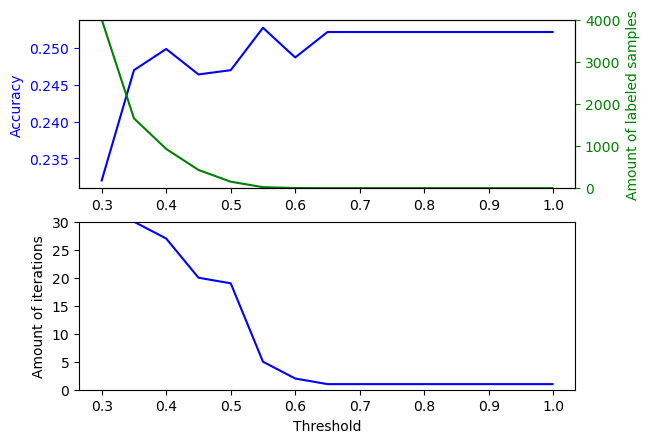

In [33]:
# ISO CALIBRATED SELF-TRAINING LOGISTIC REGRESSION
cal_self_LR_accs = []
cal_self_LR_f1s = []
cal_self_LR_precs = []
cal_self_LR_recs = []
cal_self_LR_labelled = []
cal_self_LR_rounds = []

start = time.time()

for threshold in thresholds:
    cal_self_LR = SelfTrainingClassifier(cal_LR, threshold=threshold, max_iter=30)
    
    cal_self_LR.fit(emb_train_data, y_train_all)
    
    Y_valid_emb_pred = cal_self_LR.predict(X_valid_emb)
    
    cal_self_LR_accs.append(accuracy_score(y_valid, Y_valid_emb_pred))
    cal_self_LR_f1s.append(f1_score(y_valid, Y_valid_emb_pred, average='macro')) 
    cal_self_LR_precs.append(precision_score(y_valid, Y_valid_emb_pred, average='macro')) 
    cal_self_LR_recs.append(recall_score(y_valid, Y_valid_emb_pred, average='macro')) 
    labelled_or_not = cal_self_LR.labeled_iter_
    cal_self_LR_labelled.append(labelled_or_not[np.where(labelled_or_not > 0)].shape[0])
    cal_self_LR_rounds.append(cal_self_LR.n_iter_)
    
end = time.time()

print(" -- LOGISTIC REGRESSION -- ISOTONIC -- SELF-TRAINING -- ")
print("Total instances:\t", emb_train_data.shape[0])
for i in range(thresholds.size):
    print("Threshold: %.2f" % thresholds[i].round(2), "| ", end='')
    print("Acc: %.4f" % cal_self_LR_accs[i].round(4), "\t", end='')
    print("Labelled:", cal_self_LR_labelled[i], "\t", end='')
    print("Iterations:", cal_self_LR_rounds[i], "\t", end='')
    print("F1: %.4f" % cal_self_LR_f1s[i].round(4), "\t", end='')
    print("Prec: %.4f" % cal_self_LR_precs[i].round(4), "\t", end='')
    print("Rec:%.4f" % cal_self_LR_recs[i].round(4))
    
print("Time:\t", end-start)

plotAccByThreshold(thresholds, cal_self_LR_accs, cal_self_LR_labelled, 4000, cal_self_LR_rounds)

 -- KNN -- ISOTONIC -- SELF-TRAINING -- 
Total instances:	 13902
Threshold: 0.30 | Acc: 0.2188 	Labelled: 5410 	Iterations: 22 	F1: 0.1601 	Prec: 0.2087 	Rec:0.2147
Threshold: 0.35 | Acc: 0.2205 	Labelled: 3765 	Iterations: 30 	F1: 0.1662 	Prec: 0.2082 	Rec:0.2165
Threshold: 0.40 | Acc: 0.2366 	Labelled: 1002 	Iterations: 30 	F1: 0.2139 	Prec: 0.2237 	Rec:0.2365
Threshold: 0.45 | Acc: 0.2464 	Labelled: 281 	Iterations: 10 	F1: 0.2204 	Prec: 0.2314 	Rec:0.2468
Threshold: 0.50 | Acc: 0.2424 	Labelled: 183 	Iterations: 12 	F1: 0.2176 	Prec: 0.2268 	Rec:0.2424
Threshold: 0.55 | Acc: 0.2453 	Labelled: 68 	Iterations: 4 	F1: 0.2185 	Prec: 0.2278 	Rec:0.2455
Threshold: 0.60 | Acc: 0.2458 	Labelled: 47 	Iterations: 6 	F1: 0.2184 	Prec: 0.2240 	Rec:0.2460
Threshold: 0.65 | Acc: 0.2464 	Labelled: 9 	Iterations: 2 	F1: 0.2199 	Prec: 0.2271 	Rec:0.2469
Threshold: 0.70 | Acc: 0.2464 	Labelled: 0 	Iterations: 1 	F1: 0.2199 	Prec: 0.2257 	Rec:0.2470
Threshold: 0.75 | Acc: 0.2464 	Labelled: 0 	Iterati

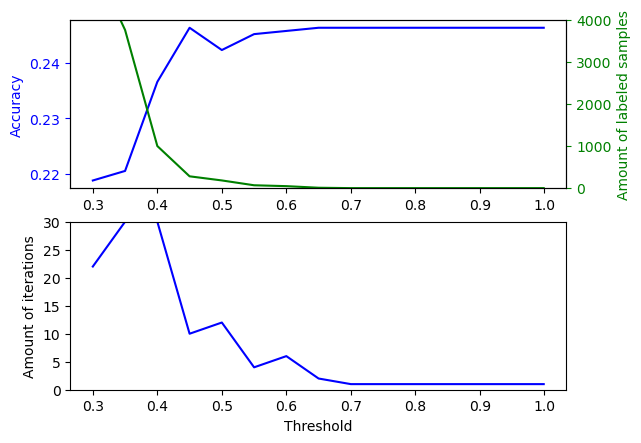

In [34]:
# ISO CALIBRATED SELF-TRAINING K-NEAREST NEIGHBOURS
cal_self_KNN_accs = []
cal_self_KNN_f1s = []
cal_self_KNN_precs = []
cal_self_KNN_recs = []
cal_self_KNN_labelled = []
cal_self_KNN_rounds = []

start = time.time()

for threshold in thresholds:
    cal_self_KNN = SelfTrainingClassifier(cal_KNN, threshold=threshold, max_iter=30)
    
    cal_self_KNN.fit(emb_train_data, y_train_all)
    
    Y_valid_emb_pred = cal_self_KNN.predict(X_valid_emb)
    
    cal_self_KNN_accs.append(accuracy_score(y_valid, Y_valid_emb_pred))
    cal_self_KNN_f1s.append(f1_score(y_valid, Y_valid_emb_pred, average='macro')) 
    cal_self_KNN_precs.append(precision_score(y_valid, Y_valid_emb_pred, average='macro')) 
    cal_self_KNN_recs.append(recall_score(y_valid, Y_valid_emb_pred, average='macro')) 
    labelled_or_not = cal_self_KNN.labeled_iter_
    cal_self_KNN_labelled.append(labelled_or_not[np.where(labelled_or_not > 0)].shape[0])
    cal_self_KNN_rounds.append(cal_self_KNN.n_iter_)
    
end = time.time()

print(" -- KNN -- ISOTONIC -- SELF-TRAINING -- ")
print("Total instances:\t", emb_train_data.shape[0])
for i in range(thresholds.size):
    print("Threshold: %.2f" % thresholds[i].round(2), "| ", end='')
    print("Acc: %.4f" % cal_self_KNN_accs[i].round(4), "\t", end='')
    print("Labelled:", cal_self_KNN_labelled[i], "\t", end='')
    print("Iterations:", cal_self_KNN_rounds[i], "\t", end='')
    print("F1: %.4f" % cal_self_KNN_f1s[i].round(4), "\t", end='')
    print("Prec: %.4f" % cal_self_KNN_precs[i].round(4), "\t", end='')
    print("Rec:%.4f" % cal_self_KNN_recs[i].round(4))
    
print("Time:\t", end-start)

plotAccByThreshold(thresholds, cal_self_KNN_accs, cal_self_KNN_labelled, 4000, cal_self_KNN_rounds)

 -- MNB -- ISOTONIC -- SELF-TRAINING -- 
Total instances:	 13902
Threshold: 0.30 | Acc: 0.2055 	Labelled: 3929 	Iterations: 30 	F1: 0.1608 	Prec: 0.1656 	Rec:0.2014
Threshold: 0.35 | Acc: 0.2280 	Labelled: 1896 	Iterations: 27 	F1: 0.2093 	Prec: 0.2148 	Rec:0.2249
Threshold: 0.40 | Acc: 0.2199 	Labelled: 1233 	Iterations: 26 	F1: 0.2046 	Prec: 0.2118 	Rec:0.2170
Threshold: 0.45 | Acc: 0.2188 	Labelled: 821 	Iterations: 15 	F1: 0.1943 	Prec: 0.1972 	Rec:0.2155
Threshold: 0.50 | Acc: 0.2234 	Labelled: 531 	Iterations: 13 	F1: 0.1965 	Prec: 0.1955 	Rec:0.2198
Threshold: 0.55 | Acc: 0.2274 	Labelled: 318 	Iterations: 19 	F1: 0.1989 	Prec: 0.1977 	Rec:0.2243
Threshold: 0.60 | Acc: 0.2314 	Labelled: 126 	Iterations: 8 	F1: 0.2012 	Prec: 0.2062 	Rec:0.2272
Threshold: 0.65 | Acc: 0.2274 	Labelled: 66 	Iterations: 5 	F1: 0.1944 	Prec: 0.1981 	Rec:0.2234
Threshold: 0.70 | Acc: 0.2297 	Labelled: 23 	Iterations: 10 	F1: 0.1958 	Prec: 0.2013 	Rec:0.2258
Threshold: 0.75 | Acc: 0.2286 	Labelled: 5 	I

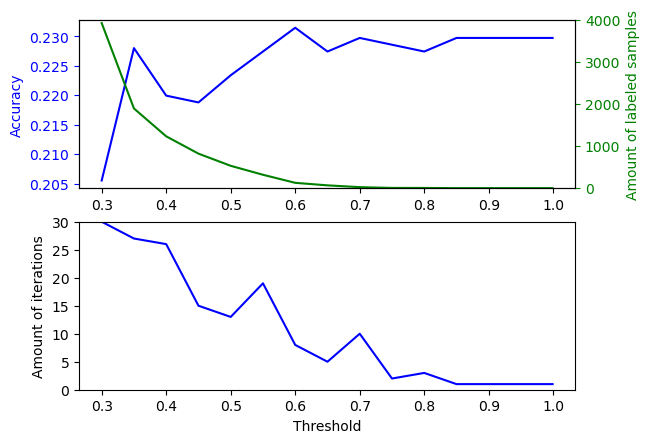

In [35]:
cal_self_MNB_accs = []
cal_self_MNB_f1s = []
cal_self_MNB_precs = []
cal_self_MNB_recs = []
cal_self_MNB_labelled = []
cal_self_MNB_rounds = []

start = time.time()

for threshold in thresholds:
    cal_self_MNB = SelfTrainingClassifier(cal_MNB, threshold=threshold, max_iter=30)
    cal_self_MNB.fit(tfidf_train_data, y_train_all)
    
    Y_valid_tfidf_pred = cal_self_MNB.predict(X_valid_tfidf)
    
    cal_self_MNB_accs.append(accuracy_score(y_valid, Y_valid_tfidf_pred))
    cal_self_MNB_f1s.append(f1_score(y_valid, Y_valid_tfidf_pred, average='macro')) 
    cal_self_MNB_precs.append(precision_score(y_valid, Y_valid_tfidf_pred, average='macro')) 
    cal_self_MNB_recs.append(recall_score(y_valid, Y_valid_tfidf_pred, average='macro')) 
    labelled_or_not = cal_self_MNB.labeled_iter_
    cal_self_MNB_labelled.append(labelled_or_not[np.where(labelled_or_not > 0)].shape[0])
    cal_self_MNB_rounds.append(cal_self_MNB.n_iter_)
    
end = time.time()

print(" -- MNB -- ISOTONIC -- SELF-TRAINING -- ")
print("Total instances:\t", tfidf_train_data.shape[0])
for i in range(thresholds.size):
    print("Threshold: %.2f" % thresholds[i].round(2), "| ", end='')
    print("Acc: %.4f" % cal_self_MNB_accs[i].round(4), "\t", end='')
    print("Labelled:", cal_self_MNB_labelled[i], "\t", end='')
    print("Iterations:", cal_self_MNB_rounds[i], "\t", end='')
    print("F1: %.4f" % cal_self_MNB_f1s[i].round(4), "\t", end='')
    print("Prec: %.4f" % cal_self_MNB_precs[i].round(4), "\t", end='')
    print("Rec:%.4f" % cal_self_MNB_recs[i].round(4))
    
print("Time:\t", end-start)

plotAccByThreshold(thresholds, cal_self_MNB_accs, cal_self_MNB_labelled, 4000, cal_self_MNB_rounds)

__Saving__ best threshold model performances to csv for test Kaggle submissions.

In [36]:
# Train models on best shown thresholds
# LR = LogisticRegression(max_iter=250)
# cal_LR = CalibratedClassifierCV(LR, method="isotonic")
# cal_self_LR = SelfTrainingClassifier(cal_LR, threshold=0.55, max_iter=30)
# cal_self_LR.fit(emb_train_data, y_train_all)

# KNN = KNeighborsClassifier(n_neighbors=20, metric="cosine")
# cal_KNN = CalibratedClassifierCV(KNN, method="isotonic")
# cal_self_KNN = SelfTrainingClassifier(cal_KNN, threshold=0.60, max_iter=30)
# cal_self_KNN.fit(emb_train_data, y_train_all)

# MNB = MultinomialNB(alpha=0.7)
# cal_MNB = CalibratedClassifierCV(MNB, method="isotonic")
# cal_self_MNB = SelfTrainingClassifier(cal_MNB, threshold=0.60, max_iter=30)
# cal_self_MNB.fit(tfidf_train_data, y_train_all)

# # Predict on test data
# cal_self_LR_pred = cal_self_LR.predict(X_test_emb)
# cal_self_KNN_pred = cal_self_KNN.predict(X_test_emb)
# cal_self_MNB_pred = cal_self_MNB.predict(X_test_tfidf)

# # Save to disk
# pred2submission(cal_self_LR_pred).to_csv("report_results/iso_self_training/cal_self_LR_pred.csv", index=False)
# pred2submission(cal_self_KNN_pred).to_csv("report_results/iso_self_training/cal_self_KNN_pred.csv", index=False)
# pred2submission(cal_self_MNB_pred).to_csv("report_results/iso_self_training/cal_self_MNB_pred.csv", index=False)